<a id='Table of Contents'></a><h1>Table of Contents</h1>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required librairies</a>  
- <a href='#setting_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a> 

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use the model `delta_lorentz` corresponding to a 
delta representing a fraction $p$ of fixed atoms and a
Lorentzian corresponding to a Brownian Translational
diffusion model for the remaining $(1-p)$ atoms
</div>

The **reference data** were generated using the above function using the following parameters $p = 0.3$ and $D = 0.145$ AA$^2\times$meV.

The model is convoluted with a Gaussian resolution function 
of Full Width Half Maximum (FWHM) equal to 0.1 meV, centered randomly in the range \[-0.01, +0.01\] meV.

Finally the data are sampled randomly from a Poisson distribution.

There is no background.

The data are fitted with a general model of a delta + a
Lorentzian, so the fitted parameters are not $p$ and $D$, but
$p$ and a $Q$-dependent HWHM.

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [1]:
# Imported required libraries
from __future__ import print_function
import sys
import os

import ipywidgets

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# install bumps (if not already installed)
import pkgutil
if not pkgutil.find_loader("bumps"):
    !{sys.executable} -m pip install bumps

 (<a href='#Table of Contents'>Top</a>)<a id='setting_fitting'></a><h2>Setting of fitting </h2>
<h3> load data, prepare data, create fitting model and set initial guesses </h3>

These settings are saved in a Python script, which will be used by Bumps to run the fit.

In [3]:
# Name of Python script containing the model
model_file = "model_fit_DeltaLorentz.py"

In [4]:
%%writefile $model_file
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *

path_to_data = './data/'

# Read the sample
f = h5py.File(path_to_data + 'DeltaBrownianDiff_Sample.hdf', 'r')
hw = f['entry1']['data1']['X'][:]
q = f['entry1']['data1']['Y'][:]
sqw = np.transpose(f['entry1']['data1']['DATA'][:])
err = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Read resolution
f = h5py.File(path_to_data + 'DeltaBrownianDiff_Resol.hdf', 'r')
res = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Force resolution function to have unit area
for i in range(len(q)):
    area = simps(res[:,i], hw)
    res[:,i] /= area   


# Fitting model 
def model_convol(x, q, scale=1, center=0, A0=0, hwhm=1, resolution=None):
    model = QENSmodels.sqwDeltaLorentz(x, q, scale, center, A0, hwhm)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
M = []

# First dataset: wavelength=5 Angstrom 
for i in range(len(q)):

    # Bumps fitting model
    Mq = Curve(model_convol, hw, sqw[:,i], err[:,i], q=q[i],          
               scale=1000, center=0.0, A0=0.5, hwhm=0.01, resolution=res[:, i])
    Mq.scale.range(0, 1e5)
    Mq.center.range(-0.1, 0.1)
    Mq.A0.range(0, 1)
    Mq.hwhm.range(0, 2)
    
    # Q-independent parameters
    if i == 0:
        QA0 = Mq.A0  
    else:
        Mq.A0 = QA0
    M.append(Mq)
        
problem = FitProblem(M)

Writing model_fit_DeltaLorentz.py


<h3> Choice of minimizer for bumps </h3>

In [5]:
w_choice_minimizer = ipywidgets.widgets.Dropdown(
    options={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"},
    value="lm",
    description='Minimizer:',)

display(w_choice_minimizer)

RHJvcGRvd24oZGVzY3JpcHRpb249dSdNaW5pbWl6ZXI6JywgaW5kZXg9NCwgb3B0aW9ucz17J1F1YXNpLU5ld3RvbiBCRkdTJzogJ25ld3RvbicsICdSYW5kb20gTGluZXMgKGV4cGVyaW1lbnTigKY=


<h3> Setting for running bumps </h3>

In [6]:
# CHOICE OF MINIMIZER
minimiser = w_choice_minimizer.value

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = 100

# output folder to save thre results
output_folder = 'QENS'

(<a href='#Table of Contents'>Top</a>)<a id='running_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above
The subfolder *output_folder* contains different results: plots and 
refined parameters

# /Users/celinedurniak/anaconda/envs/mynewenv/lib/python2.7/site-packages/bumps/cli.py model_fit_DeltaLorentz.py --fit=lm --steps=100 --store=QENS
-- Model 0 
.A0 = 0.5 in [0,1]
.center = 0 in [-0.1,0.1]
.hwhm = 0.01 in [0,2]
.q = 0.2
.scale = 1000 in [0,100000]

[chisq=1742.020(12), nllf=349275]
-- Model 1 
.A0 = 0.5 in [0,1]
.center = 0 in [-0.1,0.1]
.hwhm = 0.01 in [0,2]
.q = 0.4
.scale = 1000 in [0,100000]

[chisq=1484.954(12), nllf=297733]
-- Model 2 
.A0 = 0.5 in [0,1]
.center = 0 in [-0.1,0.1]
.hwhm = 0.01 in [0,2]
.q = 0.6
.scale = 1000 in [0,100000]

[chisq=1394.372(12), nllf=279572]
-- Model 3 
.A0 = 0.5 in [0,1]
.center = 0 in [-0.1,0.1]
.hwhm = 0.01 in [0,2]
.q = 0.8
.scale = 1000 in [0,100000]

[chisq=1347.734(12), nllf=270221]
-- Model 4 
.A0 = 0.5 in [0,1]
.center = 0 in [-0.1,0.1]
.hwhm = 0.01 in [0,2]
.q = 1
.scale = 1000 in [0,100000]

[chisq=1348.618(12), nllf=270398]
-- Model 5 
.A0 = 0.5 in [0,1]
.center = 0 in [-0.1,0.1]
.hwhm = 0.01 in [0,2]
.q = 1.2
.scale = 100

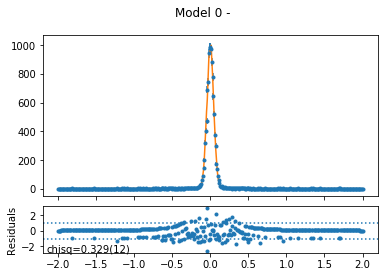

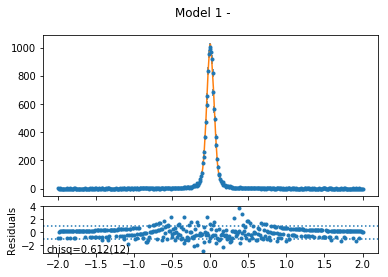

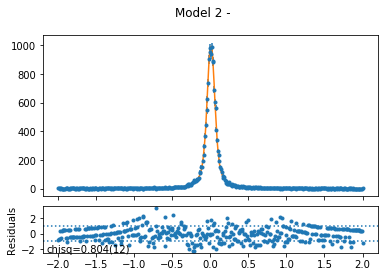

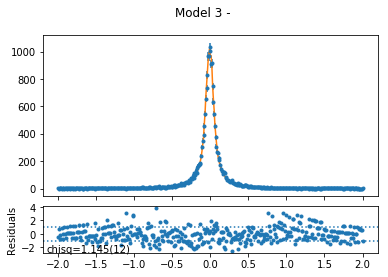

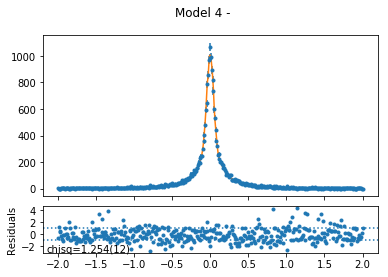

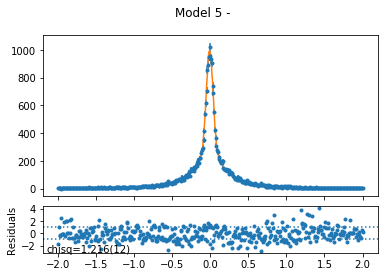

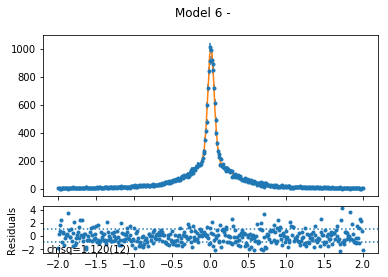

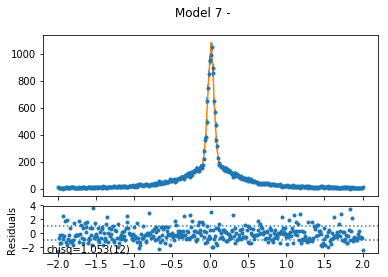

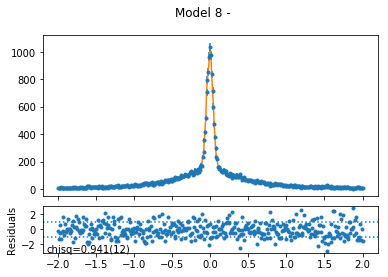

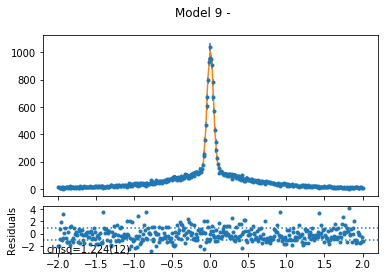

In [7]:
%run -m bumps.cli $model_file --fit=$minimiser --steps=$steps --store=$output_folder

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

In [8]:
# DISPLAY SOME RESULTS (Bumps output)
par_file = os.path.splitext(model_file)[0] + '.par'
err_file = os.path.splitext(model_file)[0] + '.err'

with open(os.path.join('.', output_folder, par_file), 'r') as fid:
    for line in fid:
        parameter, value = line.split()
        print(parameter, value)
        
with open(os.path.join(os.getcwd(), output_folder, err_file), 'r') as ferr:
    for line in ferr:
        print(line.rsplit('\n')[0])

A0 0.30220513720757
center 0.00199125928783408
hwhm 0.00527852096346405
scale 111.051447033342
center -0.000552769453215065
hwhm 0.0208223955734705
scale 135.404082347144
center -0.00105428152592762
hwhm 0.0486114323546564
scale 166.100538184585
center 3.84923714732119e-06
hwhm 0.0854199527726253
scale 200.382532038087
center -0.00098375150908078
hwhm 0.13709414587114
scale 233.517968906171
center -0.00122252443000095
hwhm 0.191658663841882
scale 256.493138498817
center -0.00458395199853033
hwhm 0.267899975854017
scale 271.508477009901
center 0.00499970133180481
hwhm 0.364789939681144
scale 292.251369747468
center 0.000260564739597183
hwhm 0.449546806822615
scale 297.950989471504
center -0.00138142292423632
hwhm 0.542691963763751
scale 308.221391048655
-- Model 0 
.A0 = 0.302205 in [0,1]
.center = 0.00199126 in [-0.1,0.1]
.hwhm = 0.00527852 in [0,2]
.q = 0.2
.scale = 111.051 in [0,100000]

[chisq=0.329(12), nllf=66.0014]
-- Model 1 
.A0 = 0.302205 in [0,1]
.center = -0.000552769 in [-0

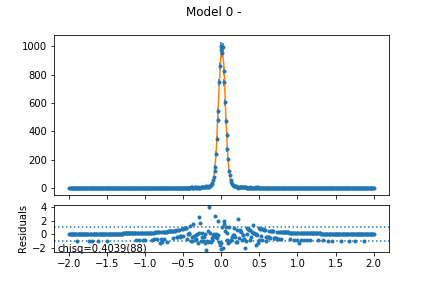

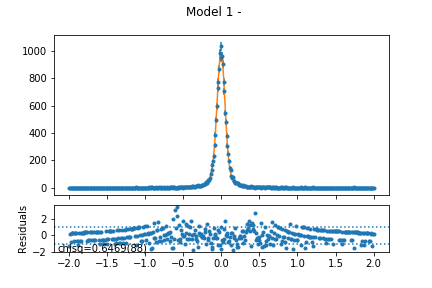

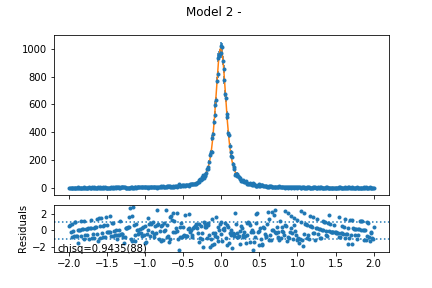

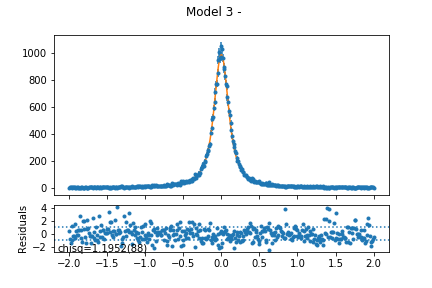

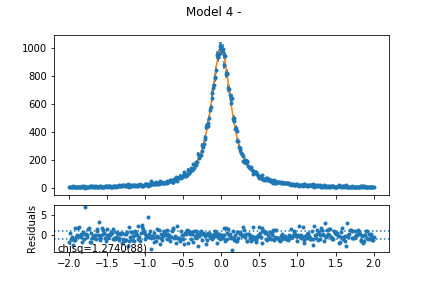

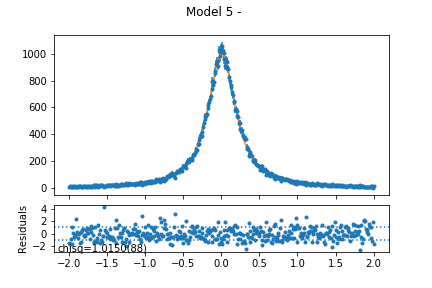

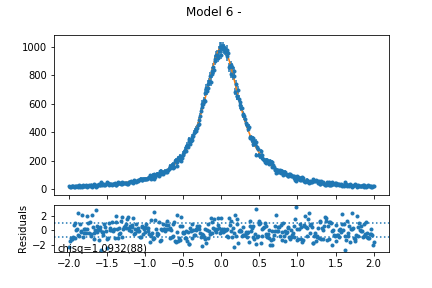

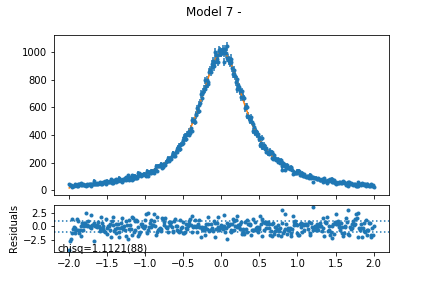

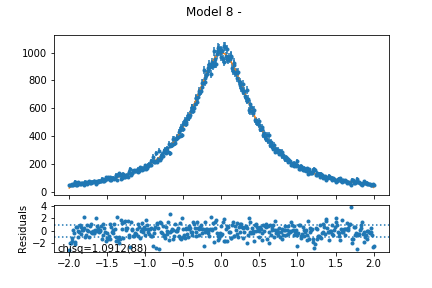

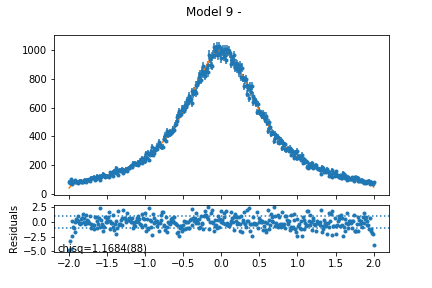

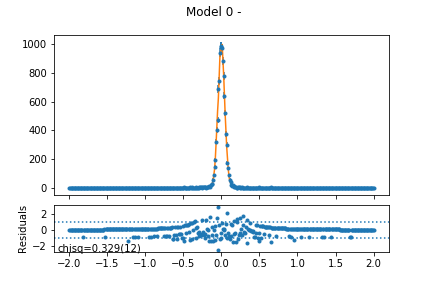

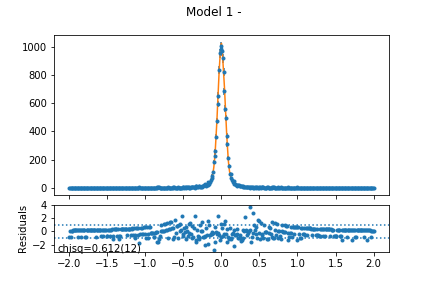

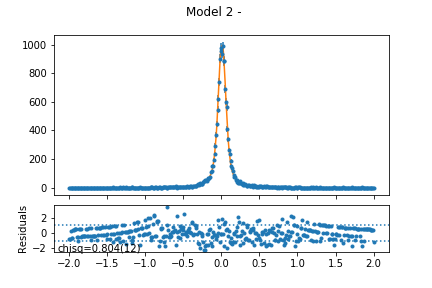

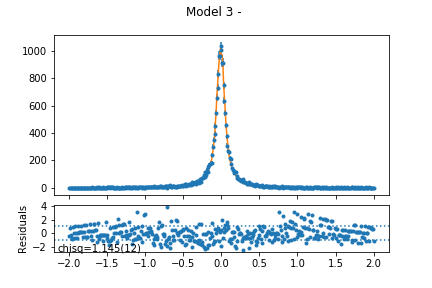

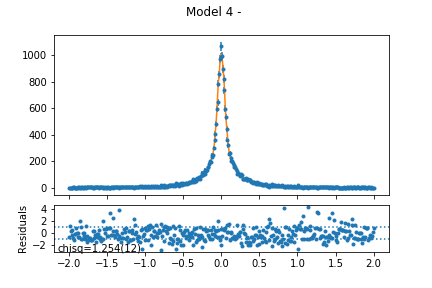

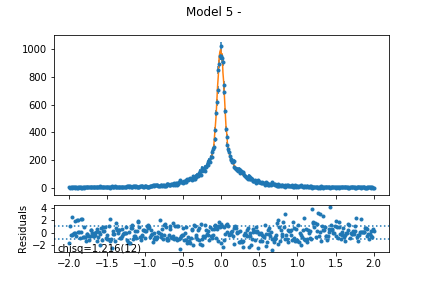

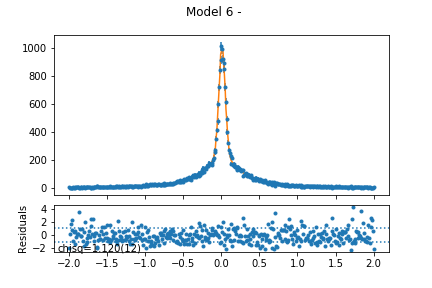

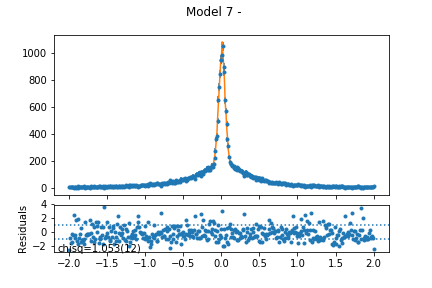

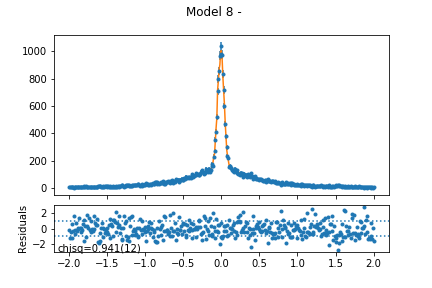

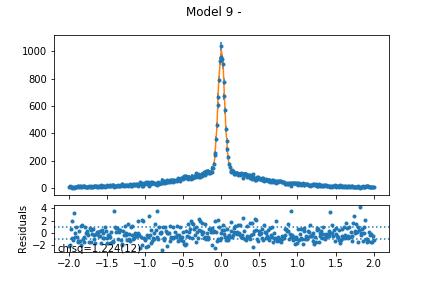

In [9]:
# Plot the fitting results

from IPython.display import display, Image
relative_output_path = os.path.join('.', output_folder)
names = [f for f in os.listdir(relative_output_path) if f.endswith('.png')]

for name in names:
    display(Image(os.path.join(relative_output_path, name)))